In [226]:
from Calculators.GED_Calculator import build_GED_calculator, build_Heuristic_calculator, build_Randomwalk_GED_calculator
# from Calculators.Product_GRaphs import RandomWalkCalculator
from Dataset import Dataset
from Experiment import experiment
import sys
import os
import traceback

from Models.SVC.GED.hybrid_prototype_selector import HybridPrototype_GED_SVC
# add the current directory to the system path
sys.path.append(os.getcwd())
from Models.SVC.GED.RandomWalk_edit import Random_Walk_edit_accelerated, Random_walk_edit_SVC
from Models.SVC.WeisfeilerLehman_SVC import WeisfeilerLehman_SVC
from Models.Graph_Classifier import GraphClassifier
from Models.SVC.Baseline_SVC import VertexHistogram_SVC,EdgeHistogram_SVC, CombinedHistogram_SVC, NX_Histogram_SVC
from Models.Blind_Classifier import Blind_Classifier
from Models.Random_Classifer import Random_Classifier
from Models.KNN_Classifer import KNN
from Models.SVC.GED.Trivial_GED_SVC import Trivial_GED_SVC
from Custom_Kernels.GEDLIB_kernel import GEDKernel
from Calculators.Dummy_Calculator import Dummy_Calculator
from Calculators.Base_Calculator import Base_Calculator
from Calculators.GEDLIB_Caclulator import GEDLIB_Calculator
from Models.SVC.GED.GED_Diffu_SVC import DIFFUSION_GED_SVC, Diffusion_GED_new
from Models.SVC.GED.Zero_GED_SVC import ZERO_GED_SVC
from Models.SVC.GED.simiple_prototype_GED_SVC import Simple_Prototype_GED_SVC
from Models.SVC.Base_GED_SVC import Base_GED_SVC, set_global_ged_calculator
from Models.KNN.GEDLIB_KNN import GED_KNN, set_global_ged_calculator_KNN
from Models.KNN.feature_KNN import Feature_KNN
import pandas as pd
from io_Manager import IO_Manager


In [227]:
DATASET_NAME="MUTAG"
PRELOAD_CALCULATORS=True
USE_NODE_LABELS="labels"
USE_EDGE_LABELS="labels"
GED_BOUND="Vertex"  # "UpperBound-Distance", "Mean-Distance", "LowerBound-Distance"
def get_classifier(ged_calculator):
    set_global_ged_calculator_KNN(ged_calculator)

    # return ZERO_GED_SVC(calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, C=1.0,kernel_type="precomputed", selection_split="classwise",prototype_size=7, aggregation_method="sum",dataset_name=DATASET.name,selection_method="k-CPS")
    # return Random_walk_edit_SVC(ged_calculator=ged_calculator, ged_bound=GED_BOUND, decay_lambda=0.1, max_walk_length=-1, C=1.0,kernel_type="precomputed", class_weight='balanced')
    # random_walk_calculator = RandomWalkCalculator(ged_calculator=ged_calculator, llambda_samples=[0.005,0.01,0.03,0.05,0.1,0.2,0.45,0.89], dataset=DATASET,ged_method=GED_BOUND)
    # random_walk_calculator = build_Randomwalk_GED_calculator(ged_calculator=ged_calculator)
    # random_walk_calculator_id = random_walk_calculator.get_identifier_name()

    # return Random_Walk_edit_accelerated(calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, decay_lambda=0.1, max_walk_length=-1, C=1.0,kernel_type="precomputed", class_weight='balanced',random_walk_calculator_id=random_walk_calculator_id)
    return Trivial_GED_SVC(calculator_id=ged_calculator.get_identifier_name(),ged_bound=GED_BOUND, C=1.0,kernel_type="precomputed", class_weight='balanced',similarity_function='k4',llambda=0.1)
    # return  Simple_Prototype_GED_SVC(calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, C=1.0,kernel_type="poly", class_weight='balanced',prototype_size=8, selection_method="k-CPS", selection_split="all",dataset_name=DATASET_NAME)
    return DIFFUSION_GED_SVC(C=0.5, llambda=0.05, calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, diffusion_function="exp_diff_kernel", class_weight='balanced', t_iterations=2)
    return Diffusion_GED_new(C=0.5, llambda=0.05, calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, diffusion_function="exp_diff_kernel", class_weight='balanced', t_iterations=2)
    # return CombinedHistogram_SVC(kernel_type='precomputed')
    # return Feature_KNN(vector_feature_list=["VertexHistogram","density","Prototype-Distance"], dataset_name=DATASET.name, prototype_size=5, selection_split="all", selection_method="TPS", metric="minkowski", calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, n_neighbors=5, weights='uniform', algorithm='auto')
def get_Dataset(dataset_name: str, ged_calculator):
    DATASET= Dataset(name=dataset_name, source="TUD", domain="Bioinformatics", ged_calculator=ged_calculator, use_node_labels=USE_NODE_LABELS, use_edge_labels=USE_EDGE_LABELS,load_now=False)
    DATASET.load()
    return DATASET, DATASET.get_calculator()

if PRELOAD_CALCULATORS:
    ged_calculator = "Heuristic_Calculator"
else:
    ged_calculator = lambda dataset, labels: build_GED_calculator(GED_edit_cost="CONSTANT", GED_calc_methods=[("IPFP","upper")], dataset=dataset, labels=labels,dataset_name=DATASET_NAME, need_node_map=True)
DATASET, ged_calculator = get_Dataset(DATASET_NAME, ged_calculator)
set_global_ged_calculator(ged_calculator)

Loading MUTAG into NetworkX from Datasets/TUD/MUTAG...
Loaded 7442 edges.
Loaded 3371 node-to-graph mappings.
Loaded 188 graph labels.
Loaded node labels for 3371 nodes.
Loaded edge labels for 7442 edges.


Converting graphs to NetworkX format: 100%|██████████| 188/188 [00:00<00:00, 2448848.30it/s]

Converted 188 graphs to NetworkX format.
Now setting up the Calculator
Loading the presaved Heuristic_Calculator for dataset MUTAG


In [228]:
# Matplotlib function to display a Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

# Matplotlib function to display a Heatmap
import matplotlib.pyplot as plt

def display_heatmap(heatmap, title="Heatmap", xlabel="Graphs", ylabel="Graphs", figsize=(10, 8),
                    highlight_rows=None, highlight_cols=None, highlight_color='red', alpha=0.25, linewidth=0):
    """
    Display a heatmap and optionally highlight full rows or columns.
    - heatmap: 2D array-like (if 1D, it will be treated as a single row).
    - highlight_rows: iterable of row indices to highlight (indices relative to the displayed matrix).
    - highlight_cols: iterable of column indices to highlight.
    - highlight_color: fill color for highlights.
    - alpha: transparency for highlights.
    - linewidth: border width for highlight rectangles (0 = no border).
    Returns the matplotlib Axes.
    """
    arr = np.array(heatmap)
    # Ensure 2D for seaborn (treat 1D as single row)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]

    plt.figure(figsize=figsize)
    ax = sns.heatmap(arr, annot=False, cmap='viridis', cbar=True)
    nrows, ncols = arr.shape

    # Add translucent rectangles to highlight full rows
    if highlight_rows is not None:
        for r in highlight_rows:
            if 0 <= r < nrows:
                rect = Rectangle((0, r), ncols, 1, facecolor=highlight_color, alpha=alpha, linewidth=linewidth, edgecolor='black' if linewidth>0 else None)
                ax.add_patch(rect)

    # Add translucent rectangles to highlight full columns
    if highlight_cols is not None:
        for c in highlight_cols:
            if 0 <= c < ncols:
                rect = Rectangle((c, 0), 1, nrows, facecolor=highlight_color, alpha=alpha, linewidth=linewidth, edgecolor='black' if linewidth>0 else None)
                ax.add_patch(rect)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    return ax

In [229]:
# split Dataset into Train and test
X_train, X_test, y_train, y_test = DATASET.train_test_split(test_size=0.2, stratify=DATASET.target, random_state=42)


In [230]:
# get for each item in the train set the idx in the original dataset
train_indices = [int(g.name) for g in X_train]
# sort the indices by their orginal order
sorted_train_indices = sorted(train_indices)
#also sort them by their labels
sorted_train_indices_by_labels = [train_indices[x] for x in sorted(range(len(train_indices)), key=lambda idx: (y_train[idx]))]
# sort by node count
# sorted_train_indices_by_size = [train_indices[x] for _, x in sorted(zip([len(X_train[idx].nodes()) for idx in train_indices], train_indices))]

# sort them by their labels primarily and secondarily by their node count

sorted_train_indices_by_size = [train_indices[x] for x in sorted(range(len(train_indices)), key=lambda idx: ( y_train[idx],len(X_train[idx].nodes())))]

    
# also sort the orginal training instances by their size
X_train_label_sorted_size = [DATASET.graphs[idx] for idx in sorted_train_indices_by_size]
Y_train_label_sorted_size = [y_train[train_indices.index(idx)] for idx in sorted_train_indices_by_size]
X_train_sorted_size = [DATASET.graphs[idx] for idx in sorted_train_indices_by_size]
Y_train_sorted_size = [y_train[train_indices.index(idx)] for idx in sorted_train_indices_by_size]

# also sort the orginal training instances by their labels
X_train_label_sorted_labels = [DATASET.graphs[idx] for idx in sorted_train_indices_by_labels]
Y_train_label_sorted_labels = [y_train[train_indices.index(idx)] for idx in sorted_train_indices_by_labels]
X_train_sorted_labels = [DATASET.graphs[idx] for idx in sorted_train_indices_by_labels]
Y_train_sorted_labels = [y_train[train_indices.index(idx)] for idx in sorted_train_indices_by_labels]



In [231]:
classifier = get_classifier(ged_calculator)

indizies_for_graphic = sorted_train_indices_by_labels
X_train_for_graphic = [DATASET.graphs[idx] for idx in indizies_for_graphic]
Y_train_for_graphic = [y_train[train_indices.index(idx)] for idx in indizies_for_graphic]
import numpy as np


labels_map =np.zeros((len(y_train), len(y_train)))
for i in range(len(y_train)):
    for j in range(len(y_train)):
        if y_train[i] == y_train[j]:
            labels_map[i][j] = 1
        else:
            labels_map[i][j] = -1

sorted_labels_map_graphic =np.zeros((len(X_train_for_graphic), len(X_train_for_graphic)))
for i in range(len(Y_train_for_graphic)):
    for j in range(len(Y_train_for_graphic)):
        if Y_train_for_graphic[i] == Y_train_for_graphic[j]:
            sorted_labels_map_graphic[i][j] = 1
        else:
            sorted_labels_map_graphic[i][j] = -1
            
heatmap = classifier.fit_transform(X_train_for_graphic,Y_train_for_graphic)

sorted_heatmap_by_size = [heatmap[x] for x in sorted(range(len(train_indices)), key=lambda idx: (len(X_train[idx].nodes()),y_train[idx]))]
sorted_labels_map_by_size = [sorted_labels_map_graphic[x] for x in sorted(range(len(train_indices)), key=lambda idx: (len(X_train[idx].nodes()),y_train[idx]))]


In [232]:
# fit the model and get the lagrgange multipliers
ged_matrix_train = ged_calculator.get_complete_matrix(method=GED_BOUND,x_graphindexes=indizies_for_graphic, y_graphindexes=indizies_for_graphic)
classifier.fit(X_train_for_graphic, Y_train_for_graphic)
# get the lagrange multipliers
lambdas = classifier.classifier.support_
support_weights = classifier.classifier.dual_coef_
# map the support weights to the original indices
weights_for_indices = np.zeros(len(X_train_for_graphic))
for support_idx, original_idx in enumerate(classifier.classifier.support_):
    weights_for_indices[original_idx] = support_weights[0][support_idx]

display(lambdas)
display(support_weights)
display(weights_for_indices)


array([  3,   4,   9,  12,  17,  18,  20,  22,  28,  32,  33,  35,  37,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  53,
        56,  57,  63,  65,  68,  72,  73,  74,  78,  79,  83,  85,  88,
        89,  91,  93,  96,  98,  99, 104, 108, 111, 113, 116, 119, 120,
       121, 122, 124, 125, 127, 129, 130, 131, 133, 134, 135, 136, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], dtype=int32)

array([[-1.5       , -1.5       , -1.5       , -1.5       , -1.5       ,
        -1.5       , -1.5       , -1.5       , -1.5       , -1.5       ,
        -1.5       , -0.79277924, -0.1830796 , -1.5       , -1.5       ,
        -1.5       , -0.896567  , -1.5       , -0.04634342, -1.5       ,
        -1.5       , -0.62166006, -1.5       , -1.41123311,  0.75      ,
         0.75      ,  0.75      ,  0.75      ,  0.75      ,  0.1005607 ,
         0.75      ,  0.75      ,  0.06234126,  0.75      ,  0.75      ,
         0.75      ,  0.75      ,  0.75      ,  0.75      ,  0.75      ,
         0.75      ,  0.75      ,  0.75      ,  0.06624874,  0.75      ,
         0.75      ,  0.75      ,  0.02267437,  0.1830796 ,  0.01722547,
         0.75      ,  0.75      ,  0.75      ,  0.75      ,  0.75      ,
         0.75      ,  0.0394325 ,  0.04423517,  0.75      ,  0.75      ,
         0.75      ,  0.75      ,  0.75      ,  0.75      ,  0.75      ,
         0.07384551,  0.73277453,  0.03489406,  0.4

array([ 0.        ,  0.        ,  0.        , -1.5       , -1.5       ,
        0.        ,  0.        ,  0.        ,  0.        , -1.5       ,
        0.        ,  0.        , -1.5       ,  0.        ,  0.        ,
        0.        ,  0.        , -1.5       , -1.5       ,  0.        ,
       -1.5       ,  0.        , -1.5       ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.5       ,  0.        ,
        0.        ,  0.        , -1.5       , -1.5       ,  0.        ,
       -0.79277924,  0.        , -0.1830796 ,  0.        , -1.5       ,
       -1.5       , -1.5       , -0.896567  , -1.5       , -0.04634342,
       -1.5       , -1.5       , -0.62166006, -1.5       , -1.41123311,
        0.75      ,  0.        ,  0.        ,  0.75      ,  0.        ,
        0.        ,  0.75      ,  0.75      ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.75      ,  0.        ,
        0.1005607 ,  0.        ,  0.        ,  0.75      ,  0.  

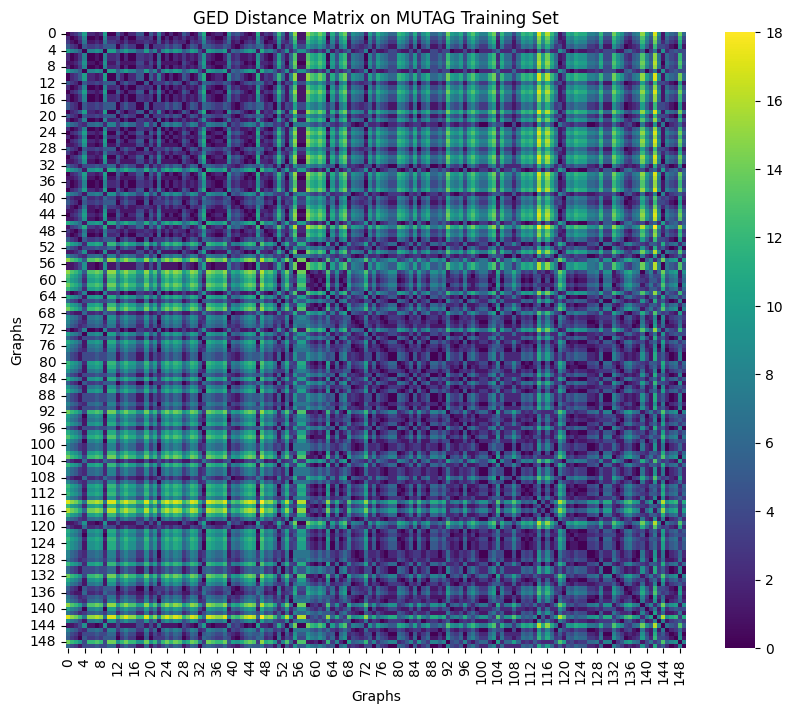

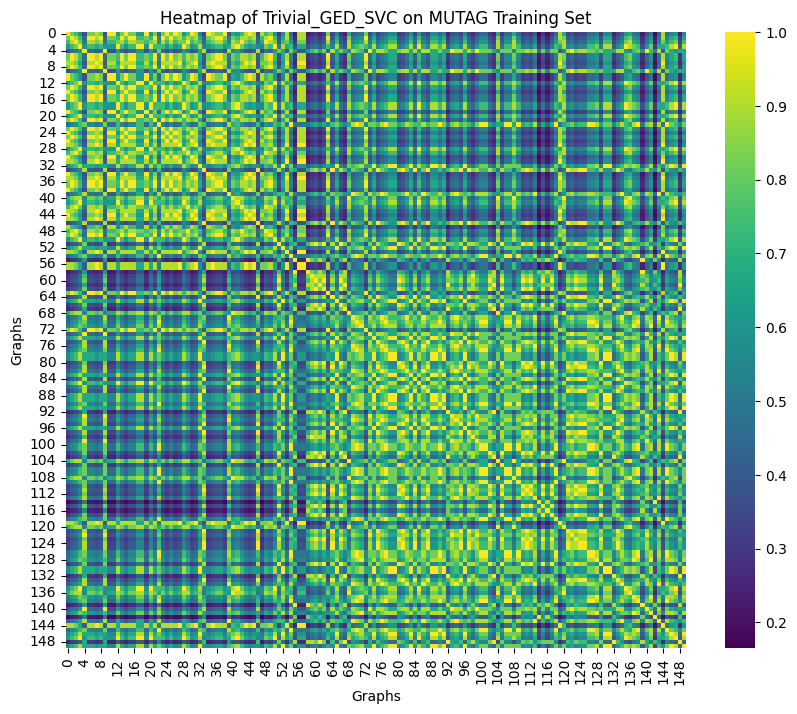

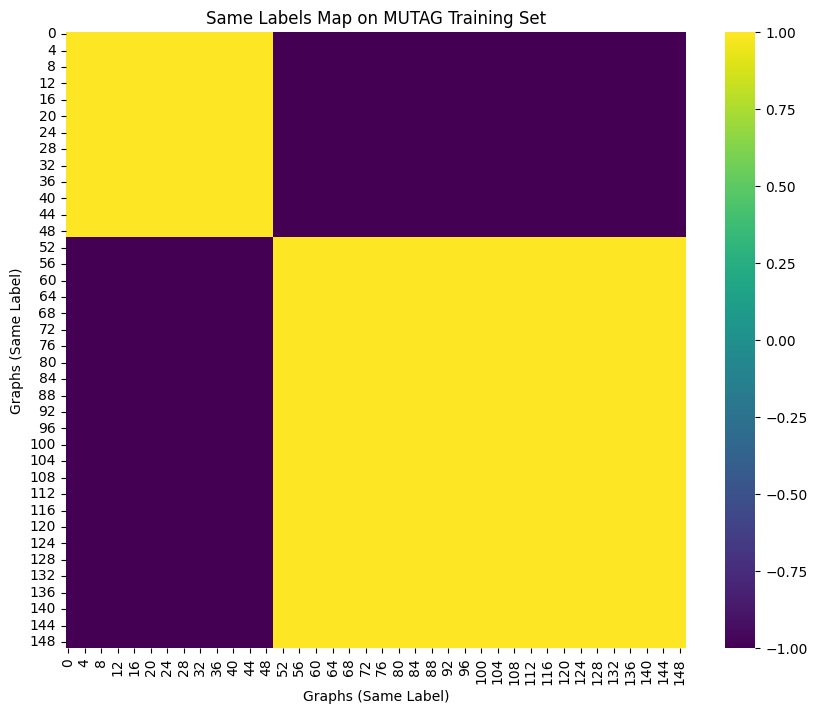

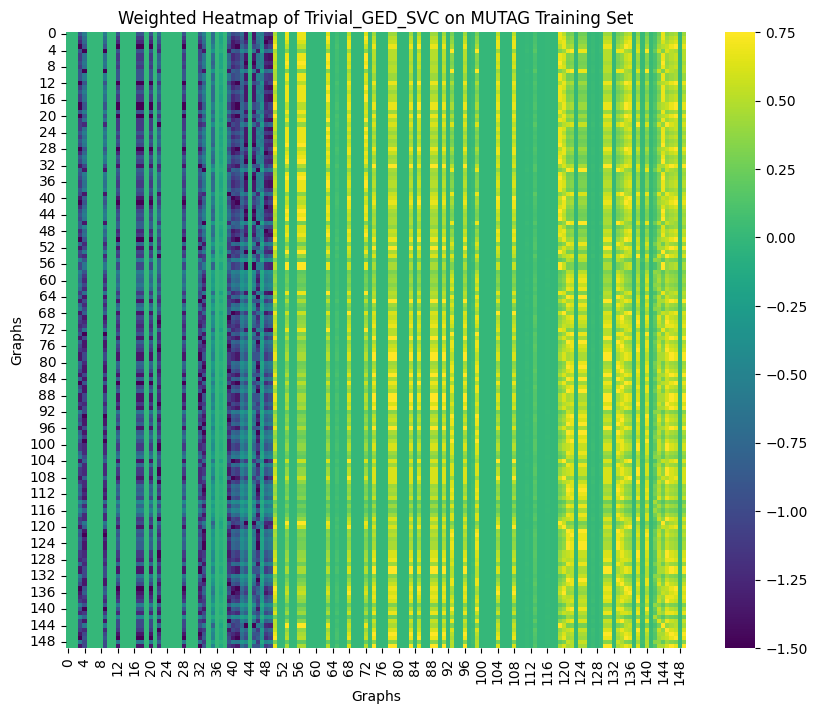

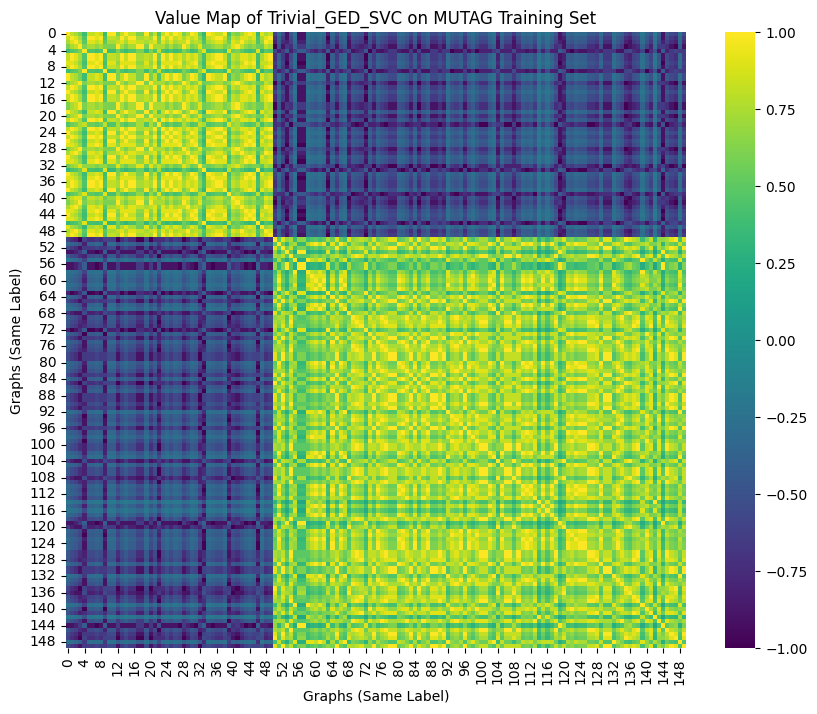

<Axes: title={'center': 'Value Map of Trivial_GED_SVC on MUTAG Training Set'}, xlabel='Graphs (Same Label)', ylabel='Graphs (Same Label)'>

In [233]:

display_heatmap(ged_matrix_train, title=f"GED Distance Matrix on {DATASET.name} Training Set")
# sort the heatmap on on axis by node size

display_heatmap(heatmap, title=f"Heatmap of {classifier.__class__.__name__} on {DATASET.name} Training Set")
display_heatmap(sorted_labels_map_graphic, title=f"Same Labels Map on {DATASET.name} Training Set", xlabel="Graphs (Same Label)", ylabel="Graphs (Same Label)")
# weighted Heatmap with the dualange multipliers
weighted_heatmap = heatmap * weights_for_indices
display_heatmap(weighted_heatmap, title=f"Weighted Heatmap of {classifier.__class__.__name__} on {DATASET.name} Training Set", xlabel="Graphs", ylabel="Graphs")    
# display_heatmap([y_train], title="labels of the training set")
value_map=heatmap * sorted_labels_map_graphic
display_heatmap(value_map, title=f"Value Map of {classifier.__class__.__name__} on {DATASET.name} Training Set", xlabel="Graphs (Same Label)", ylabel="Graphs (Same Label)")


# have the model predict on the train set 


In [234]:
# now the heatpmaps for the test data to the train data

# sort the test data by their labels primarily and secondarily by their node count
test_indices = [int(g.name) for g in X_test]
# sort the indices by their orginal order
sorted_test_indices = sorted(test_indices)
#also sort them by their labels
sorted_test_indices_by_labels = [x for _, x in sorted(zip(y_test, test_indices))]
# sort them by their labels primarily and secondarily by their node count

sorted_test_indices_by_labels_and_size = [test_indices[x] for x in sorted(range(len(test_indices)), key=lambda idx: (y_test[idx], y_test[idx]*len(X_test[idx].nodes())))]




X_test_label_sorted = [DATASET.graphs[idx] for idx in sorted_test_indices_by_labels_and_size]
Y_test_label_sorted = [y_test[test_indices.index(idx)] for idx in sorted_test_indices_by_labels_and_size]
X_test_sorted = [DATASET.graphs[idx] for idx in sorted_test_indices_by_labels_and_size]
Y_test_sorted = [y_test[test_indices.index(idx)] for idx in sorted_test_indices_by_labels_and_size]
# get the test_matrix

labels_map =np.zeros((len(y_test), len(y_train)))
for i in range(len(y_test   )):
    for j in range(len(y_train)):
        if y_test[i] == y_train[j]:
            labels_map[i][j] = 1
        else:
            labels_map[i][j] = -1

sorted_labels_map =np.zeros((len(Y_test_label_sorted), len(Y_train_label_sorted_labels)))
for i in range(len(Y_test_label_sorted)):
    for j in range(len(Y_train_label_sorted_labels)):
        if Y_test_label_sorted[i] == Y_train_label_sorted_labels[j]:
            sorted_labels_map[i][j] = 1
        else:
            sorted_labels_map[i][j] = -1



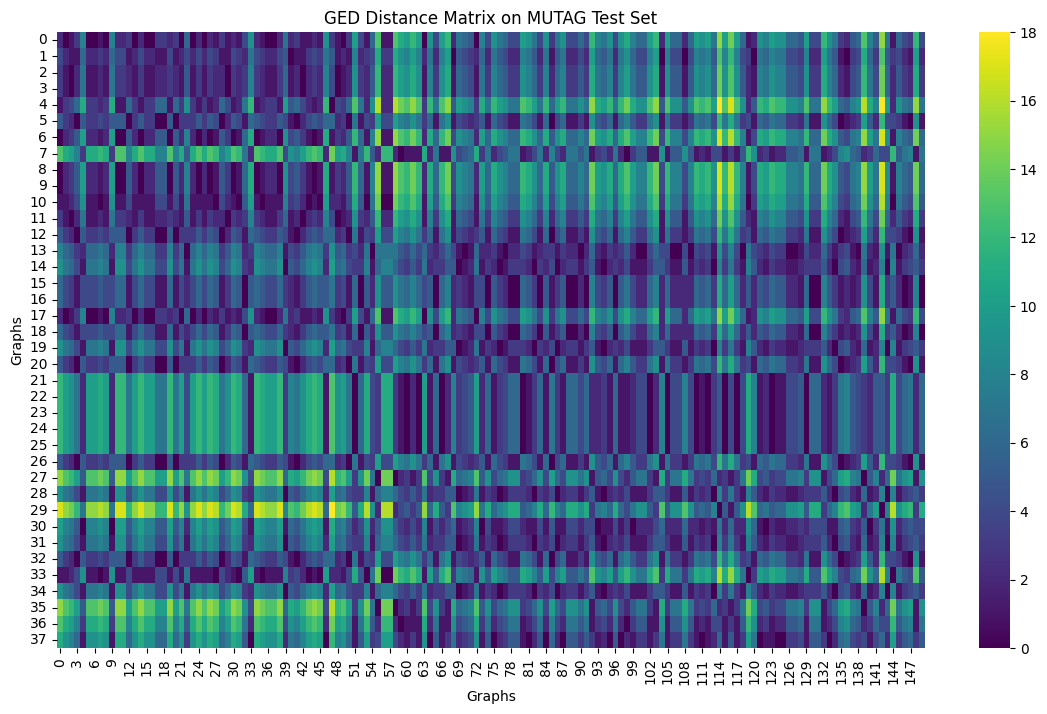

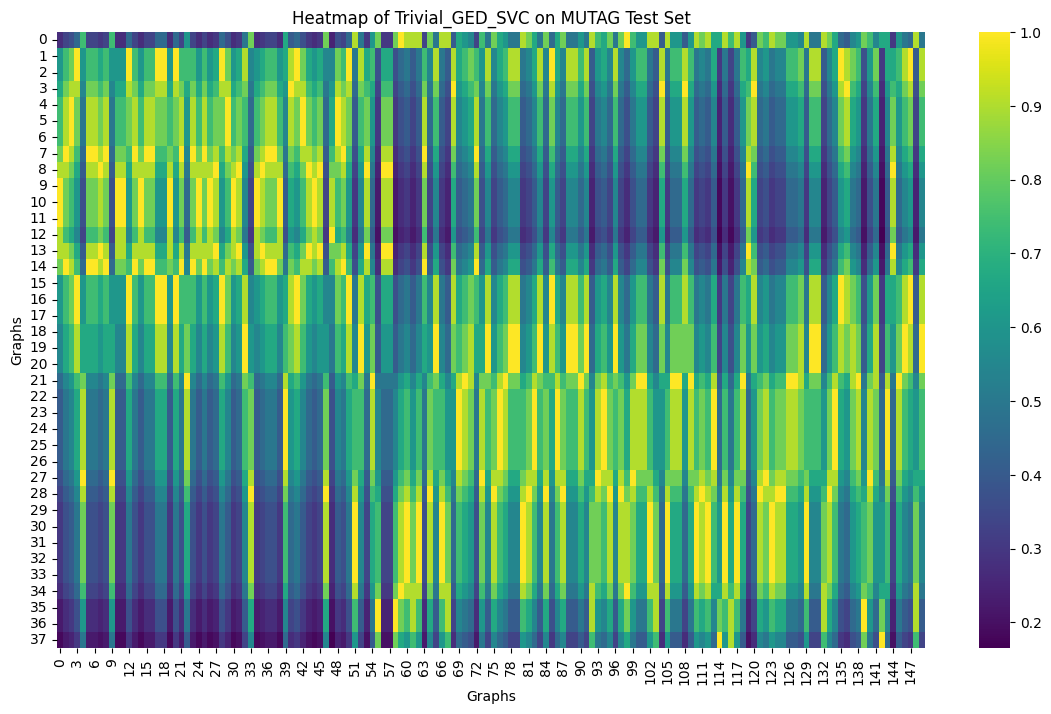

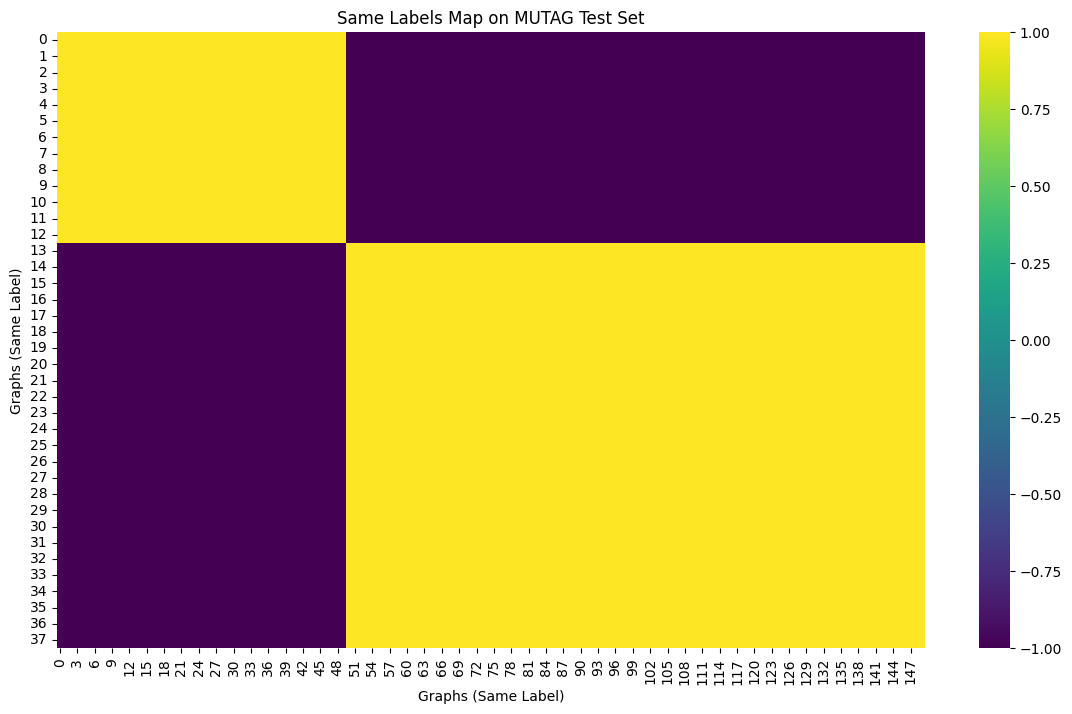

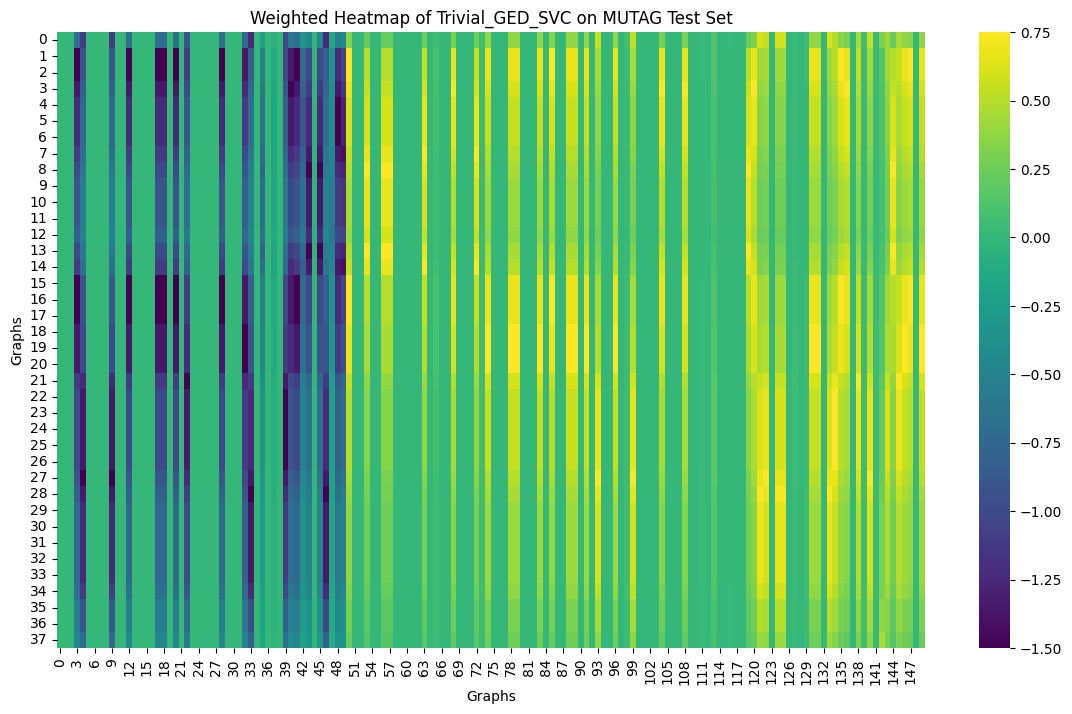

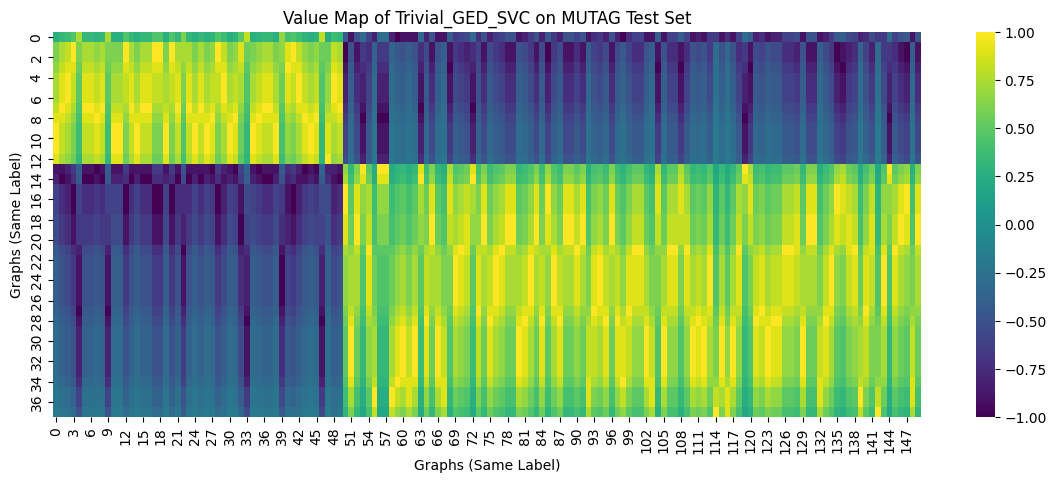

<Axes: title={'center': 'Value Map of Trivial_GED_SVC on MUTAG Test Set'}, xlabel='Graphs (Same Label)', ylabel='Graphs (Same Label)'>

In [235]:
ged_matrix_test = ged_calculator.get_complete_matrix(method=GED_BOUND,x_graphindexes=sorted_test_indices_by_labels, y_graphindexes=sorted_train_indices_by_labels)
display_heatmap(ged_matrix_test, title=f"GED Distance Matrix on {DATASET.name} Test Set",figsize=(14, 8))
heatmap_test = classifier.transform(X_test_label_sorted)
display_heatmap(heatmap_test, title=f"Heatmap of {classifier.__class__.__name__} on {DATASET.name} Test Set", figsize=(14, 8))
display_heatmap(sorted_labels_map, title=f"Same Labels Map on {DATASET.name} Test Set", xlabel="Graphs (Same Label)", ylabel="Graphs (Same Label)", figsize=(14, 8))
# weighted Heatmap with the dualange multipliers
weighted_heatmap_test = heatmap_test * weights_for_indices
display_heatmap(weighted_heatmap_test, title=f"Weighted Heatmap of {classifier.__class__.__name__} on {DATASET.name} Test Set", xlabel="Graphs", ylabel="Graphs", figsize=(14, 8))
# display_heatmap([y_train], title="labels of the training set")
value_map=heatmap_test * sorted_labels_map
display_heatmap(value_map, title=f"Value Map of {classifier.__class__.__name__} on {DATASET.name} Test Set", xlabel="Graphs (Same Label)", ylabel="Graphs (Same Label)", figsize=(14, 5))


In [236]:
classifier.fit(X_train_label_sorted, Y_train_label_sorted)

NameError: name 'X_train_label_sorted' is not defined

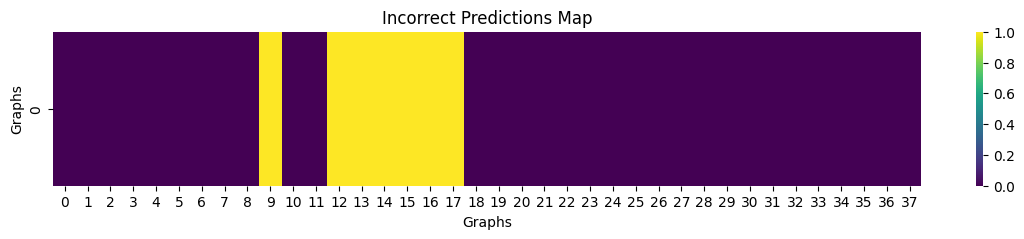

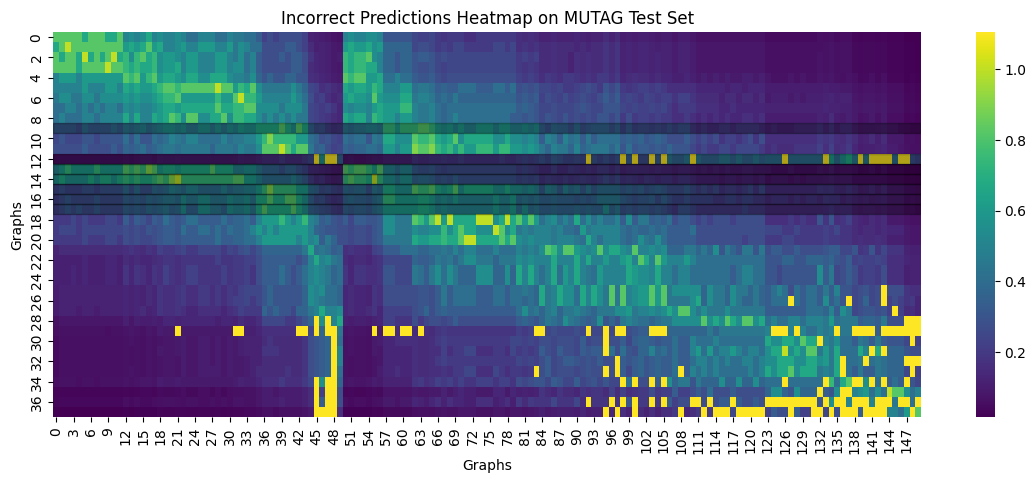

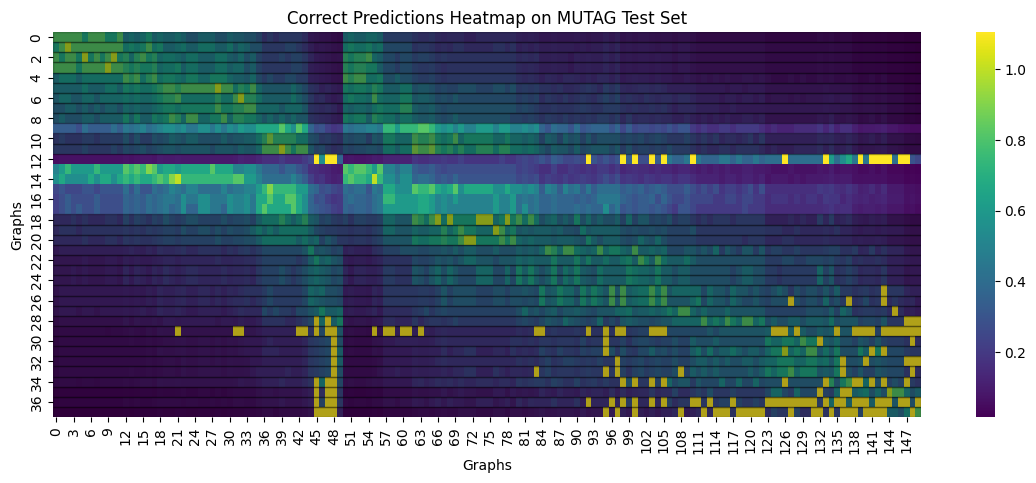

<Axes: title={'center': 'Correct Predictions Heatmap on MUTAG Test Set'}, xlabel='Graphs', ylabel='Graphs'>

In [ ]:
# get predictions for the test set
y_pred = classifier.predict(X_test_label_sorted)
y_pred_probabilities = classifier.predict_proba(X_test_label_sorted)
# where the predictions are correct 1 else 0
correct_predictions = (y_pred == Y_test_label_sorted).astype(int)
# create a heatmap of the kernel matrix (heatmap_test), where the incorrect predictions are highlighted
incorrect_predictions = (y_pred != Y_test_label_sorted).astype(int)
# fist visualize the incorrect predictions as a heatmap
display_heatmap(incorrect_predictions, title="Incorrect Predictions Map", xlabel="Graphs", ylabel="Graphs", figsize=(14, 2))

# than use the incorrect_predictions to highlight the columns in the heatmap
display_heatmap(heatmap_test, title=f"Incorrect Predictions Heatmap on {DATASET.name} Test Set", xlabel="Graphs", ylabel="Graphs", figsize=(14, 5), highlight_rows=np.where(incorrect_predictions == 1)[0], highlight_color='black', alpha=0.3, linewidth=1)

# visualize the predictions as a heatmap
display_heatmap(heatmap_test, title=f"Correct Predictions Heatmap on {DATASET.name} Test Set", xlabel="Graphs", ylabel="Graphs", figsize=(14, 5), highlight_rows=np.where(correct_predictions == 1)[0], highlight_color='black', alpha=0.3, linewidth=1)
